In [4]:
import pandas as pd
import numpy as np
from scipy import sparse
%matplotlib inline
import matplotlib.pyplot as plt
import mglearn
import sklearn
from sklearn.model_selection import train_test_split

In [11]:
!pip install graphviz

You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Naive Bayes 

    logistic과 linearSVC보다 훈련 속도가 빠르지만 일반화 성능이 좋지 않음.
    선형모델로는 학습이 오래 걸리는 '큰 데이터셋'에서는 쓸만하며 종종 사용된다고.

# Decision Tree

    정답에 가장 빨리 도달하는 yes / no 질문 목록을 학습한다는 뜻. 연속적인 데이터의 경우 'feature i는 값 a보다 큰가?' 와 같은 형태.

다만 분류를 지나치게 많이 해서 pure node(타깃 하나로만 이루어진 노드)의 수가 많을 경우 overfitting.

## overfit 방지 방법은 크게 두 가지
* 트리 생성을 일찍 중단하는 '사전 가지치기 : pre-pruning'
* 트리를 만든 후 데이터 포인트가 적은 노드를 삭제하거나 병합하는 post-pruning(or pruning)

사전 가지치기의 경우 '최대 깊이'나 '리프노드 개수'를 제한, 또는 노드 분할을 위한 최소 포인터 개수를 지정하는 방식.<br>
sklearn은 사전 가지치기만 지원하며, DecisionTreeRegressor, DecisionTreeClassifier로 구현되어 있다.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [5]:
X_train, X_test, y_train, y_test  = train_test_split(
cancer.data, cancer.target, stratify=cancer.target, random_state = 42)

In [6]:
tree = DecisionTreeClassifier(random_state = 0)
tree.fit(X_train, y_train)
print("train set acc: {:3f}".format(tree.score(X_train, y_train)))
print("test set acc: {:3f}".format(tree.score(X_test, y_test)))
# 깊이 제한이 없어서 train set의 정확도가 100이 나온다.

train set acc: 1.000000
test set acc: 0.937063


In [7]:
tree4 = DecisionTreeClassifier(random_state = 0, max_depth=4)
tree4.fit(X_train, y_train)
print("train set acc: {:3f}".format(tree4.score(X_train, y_train)))
print("test set acc: {:3f}".format(tree4.score(X_test, y_test)))

train set acc: 0.988263
test set acc: 0.951049


시각화를 위해서는 tree module의 export_graphviz 함수로 시각화.

In [13]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file = "tree.dot", class_names=['악성', '양성'],feature_names = cancer.feature_names,
               impurity=False, filled=True)

In [17]:
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

전체 트리를 다 보는 건 어려운 편이라, 보통 트리가 어떻게 작동하는지 요약하는 속성을 확인한다.

가장 많이 쓰이는 특성은 feature importance. 

0과 1 사이의 숫자로, 각 특성의 숫자 중 0은 전혀 쓰이지 않았다는 뜻 / 1은 완벽히 타깃 클래스 예측했다는 뜻

In [18]:
print("feature importance: {}".format(tree.feature_importances_))

feature importance: [0.         0.00752597 0.         0.         0.00903116 0.
 0.00752597 0.         0.         0.         0.00975731 0.04630969
 0.         0.00238745 0.00231135 0.         0.         0.
 0.         0.00668975 0.69546322 0.05383211 0.         0.01354675
 0.         0.         0.01740312 0.11684357 0.01137258 0.        ]


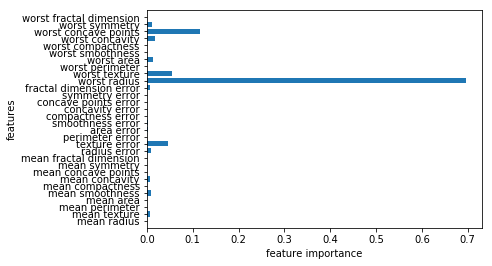

In [20]:
def plot_feature_importance_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align = 'center')
    plt.yticks(np.arange(n_features),cancer.feature_names)
    plt.xlabel("feature importance")
    plt.ylabel("features")
    plt.ylim(-1, n_features)
plot_feature_importance_cancer(tree)

그렇다고 다른 특성이 유용하지 않다는 건 아니다. 단지 트리가 그 특성을 선택하지 않았을 뿐이며, 다른 특성이 동일한 정보를 가지고 있을 수도 있다.

또한, 특성이 어떤 클래스를 지칭하는지는 모른다. 예컨대 worst radius라는 특성이 클래스를 구분하는 변수이지만, 이 변수가 양성인지 악성인지는 모름.

feature와 클래스 사이의 관계가 간단하지는 않을 수 있음. 예컨대

아래 그림은 X[1] 데이터만 사용한 결과임. 단순히 비례 / 반비례라고 말할 수는 없는 데이터 모양을 띠고 있다.

Feature importances: [0. 1.]


ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

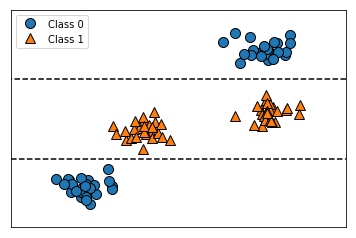

In [21]:
tree2 = mglearn.plots.plot_tree_not_monotone()
display(tree2)

### 트리모델의 가장 큰 문제는, 훈련 데이터 바깥의 새로운 데이터를 예측할 능력이 없다는 점.
* 시계열 데이터와는 잘 맞지 않는다는 걸 말한다.

트리 데이터는 훈련set의 예측도를 100까지 끌어올릴 수 있으나, 모델이 가진 데이터 범위를 벗어나면 예측 불가능.

- 최대장점: 시각화가 쉬우므로 비전문가에게 이해시키기 쉽다. overfit을 막는 데에는 max_depth, max_leaf_node, min_sample_leaf 중 하나만 지정해도 충분하다. 데이터 스케일에 구애받지 않으므로 전처리가 필요 없다. 스케일이 서로 다르거나 binary / 연속적인 값 둘 다 포함되어 있을 때도 작동.
- 단점: 사전 가지치기를 해도 일반화 성능이 좋은 편이 아님.

==> 그래서 보통 decision tree ensemble형태로 사용한다고.

# Decision Tree Ensemble - Random Forest, gradient boosting 

### Random Forest

training set에 overfit되는 기존 tree model의 단점을 보완. '여러 다른 decision tree'의 묶음 형태.

서로 다른 방향으로 overfit된 tree를 많이 만들고 그 결과를 평균냄 = 예측 성능은 유지하며 overfit을 줄이는 것이 증명됨.

== Decision Tree를 많이 만들어야 함. 

트리를 만들 때 생성하는 포인트를 무작위로 선택하거나 / 분할 테스트에서 특성을 무작위로 선택하는 방법 두 가지가 있다.

### <생성방식>

* n_sample 개의 데이터포인트 중에서 무작위로 n_sample 횟수만큼 반복 추출 (무작위 반복 추출이기에, 같은 데이터가 여러 번 추출될 수도 있다)
  
  == 원래 데이터셋과 크기는 같지만 누락 / 중복 데이터가 포함된 형태.
  
  
* 이 데이터셋으로 Decision Tree를 만든다. 
    
    그런데 Decision Tree를 만들기 위한 feature도 전체 데이터셋에서 무작위로 선택한 후, 이 선택된 것들 중에서 최선의 테스트를 찾는다. (몇 개의 특성을 고를지는 max_features 변수로 조절)

즉, 랜덤 포레스트의 트리가 조금씩 다른 데이터셋 사용 + feature의 일부만 사용 = 트리의 각 분기마다 다른 feature 부분집합을 사용.

== 랜덤 포레스트의 모든 트리가 서로 달라지게 된다. (Random Forest)

랜덤 포레스트 안에 만들어진 트리의 개수는 n_estimators 매개변수로 설정

핵심은 max_features. 값이 커질수록 랜덤 포레스트의 트리들이 비슷해지고, 가장 두드러진 특징을 데이터에 맞춘다.

값이 작아지면 랜덤 포레스트마다 트리들이 달라지고, 각 트리는 데이터에 맞추기 위해 깊이가 깊어진다.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(
X, y, stratify = y, random_state = 42)

In [24]:
forest = RandomForestClassifier(n_estimators = 5, random_state = 2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

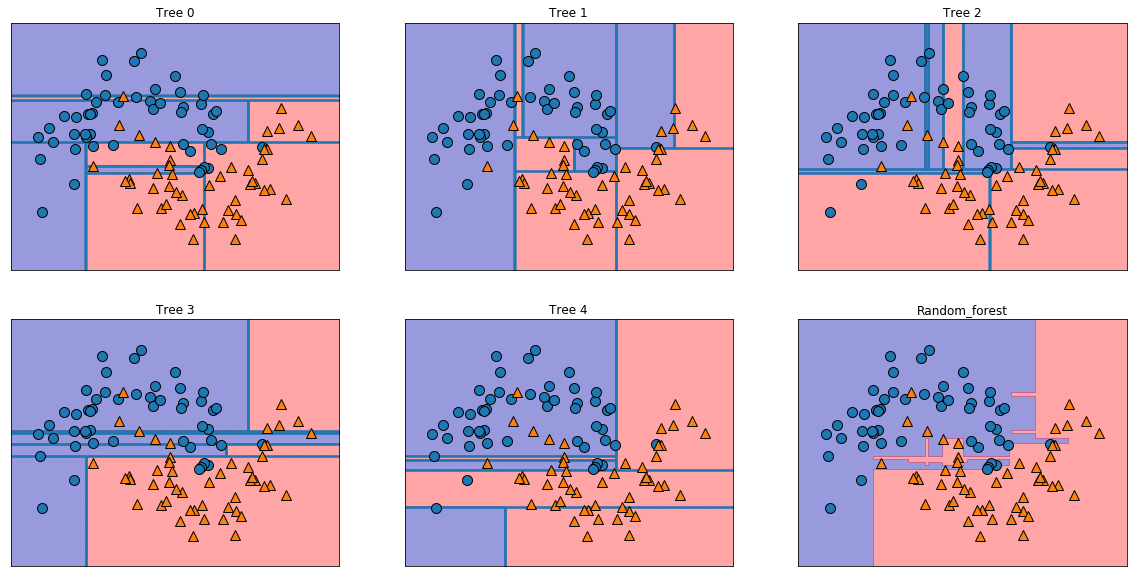

In [26]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X,y,tree, ax = ax)

mglearn.plots.plot_2d_separator(forest, X, fill=True, ax = axes[-1,-1], alpha = .4)
axes[-1,-1].set_title('Random_forest')
mglearn.discrete_scatter(X[:,0],X[:,1],y)

다섯 개가 만든 트리의 경계는 다르다. 샘플링 때문에, 트리마다 feature가 다르고 데이터셋이 다르기 때문.

이것들을 합치기 때문에, 개개의 트리보다 overfit 정도가 낮은 decision boundary를 만들어낸다. 실제 애플리케이션에서는 수백, 수천개의 트리를 쓰기에 경계가 더 부드럽다.

일반적으로 랜덤포레스트에서 제공하는 feature importance(특성 중요도)가 개별 tree의 값보다 믿을 만 하다.

In [28]:
X_train, X_test, y_train, y_test  = train_test_split(
cancer.data, cancer.target, stratify=cancer.target, random_state = 0)
forest = RandomForestClassifier(n_estimators=100,random_state=0)
forest.fit(X_train, y_train)
print("train set acc: {:3f}".format(forest.score(X_train, y_train)))
print("test set acc: {:3f}".format(forest.score(X_test, y_test)))

train set acc: 0.997653
test set acc: 0.944056


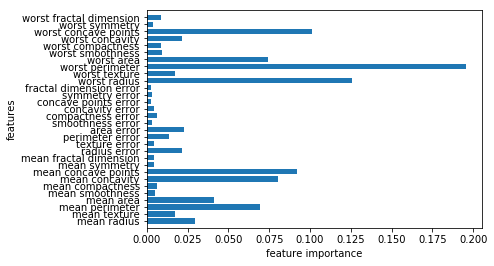

In [31]:
plot_feature_importance_cancer(forest)

## 정리

회귀와 분류에서 랜덤 포레스트는 널리 사용되는 ML 알고리즘. 성능 좋은 편 / 매개변수 튜닝 얼마 없이도 작동 / 스케일 맞출 필요 없음

멀티코어 프로세스일 때는 n_jobs 변수로 사용할 코어 수 지정도 가능하다. (-1로 설정 시 모든 코어 사용)

차원이 높고 sparse한 데이터(텍스트)에는 잘 작동하지 않는다. 선형 모델보다 많은 메모리를 사용하며 훈련과 예측이 느리다. 속도와 메모리 제약이 있다면 선형 모델이 낫다.

n_estimator는 클수록 좋고, max_feature와 max_depth는 overfit을 줄이고 regularization을 위해 쓴다고 생각하면 좋다. max_feature는 기본값 그대로 쓰는 편. classifier에서는 sqrt(n_features), regression에서는 n_features이다.

# Gradient Boosting Regression Tree. 

이전 트리의 오차를 보완하는 방식으로, 순차적으로 트리를 생성함. random성을 쓴 게 아니라 강력한 사전 가지치기를 적용함.

사전 가지치기를 쓰기에 메모리 적게 쓰고 예측도 빠르다. 트리가 많아질수록 성능 향상.

업계에서도 쓰이며, 매개변수 설정에 조금 더 민감하지만 잘 조정하면 정확도가 높다.

(이전 트리의 오차를 얼마나 강하게 보정할 것인지 = learning rate)

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
print("train set acc: {:3f}".format(gbrt.score(X_train, y_train)))
print("test set acc: {:3f}".format(gbrt.score(X_test, y_test)))

train set acc: 1.000000
test set acc: 0.958042


In [37]:
# overfit을 막기 위해 트리의 깊이를 줄이거나, learning rate를 낮춘다.
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)
print("train set acc: {:3f}".format(gbrt.score(X_train, y_train)))
print("test set acc: {:3f}".format(gbrt.score(X_test, y_test)))

train set acc: 0.995305
test set acc: 0.965035


In [36]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)
print("train set acc: {:3f}".format(gbrt.score(X_train, y_train)))
print("test set acc: {:3f}".format(gbrt.score(X_test, y_test)))

train set acc: 0.995305
test set acc: 0.944056


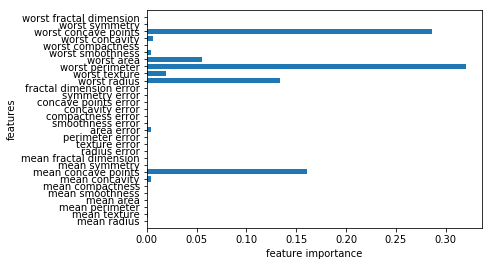

In [38]:
plot_feature_importance_cancer(gbrt)

gbrt의 경우, 일부 특성을 완전히 무시하고 있다.

보통은 더 안정적인 랜덤포레스트를 우선 적용. 예측시간이 중요하거나 마지막 성능까지 쥐어짜야 할 경우 gradient boosting을 사용하면 도움이 된다.

* Gbrt의 경우 매개변수 조정이 핵심 / 훈련시간이 길다 / sparse한 고차원 데이터에서는 작동하지 않음

    feature scale 조절할 필요 없고, binary feature이 연속적인 feature에서도 잘 동작함. 
    
   
* 핵심 hyperparameter는 n_estimators / learning_rate이다. 
    learning rate가 낮으면 비슷한 복잡도의 모델을 만들기 위해 더 많은 트리가 필요
    
    **Gbrt에서 n_estimators가 높으면 모델이 복잡해져 overfit 가능성이 커진다.**
    
    그래서 보통 가용시간, 메모리한도에서 n_estimator 설정하고 적절한 learning_rate를 찾는다.
    통상적으로 Gbrt 모델에서는 max_depth를 작게 설정 (최대 깊이가 5를 넘어서지 않는다)


## 대규모 머신러닝 문제에 Gradient Boosting을 쓰려면 xgboost 패키지 / 파이썬 인터페이스 검토

# SVM

각 training data가 클래스 사이의 decision boundary에 얼마나 중요한지를 학습함.

일반적으로 데이터 일부만이 결정 경계를 만드는 데 영향을 주기 마련. (경계에 위치한 데이터들)

== 이런 데이터들을 support vector라고 함.

새로운 데이터는 각 서포트 벡터와의 거리를 측정하고, classification은 서포트 벡터까지의 거리에 기반한다. support vector의 중요도는 training 과정에서 학습함. (svc 객체의 dual_coef_로 저장된다)

## 커널 기법.

데이터셋에 비선형 특성 (예컨대 feature의 제곱과 같은)을 추가해 선형 모델을 강화할 수도 있지만, 정확성을 높이기 위해 아무렇게나 feature를 추가하면 연산비용이 늘어난다.

커널 기법을 사용해, 위와 같이 데이터를 확장하지 않고도 고차원에서 classifier 학습이 가능함. '실제로 데이터를 확장하지 않고도, 확장된 특성과 데이터 간 스칼라 곱'을 계산함.

데이터를 고차원 공간에 매핑하는 방법은 '가우시안 커널(rbf)', 특성의 가능한 조합을 지정된 차수까지 모두 계산하는 다항식 커널이 있다. 가우시안 커널은 모든 차수의 모든 다항식을 고려한다고 이해하면 됨.

In [40]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel = 'rbf', C=10, gamma=.1).fit(X,y)

Text(0, 0.5, 'feature 1')

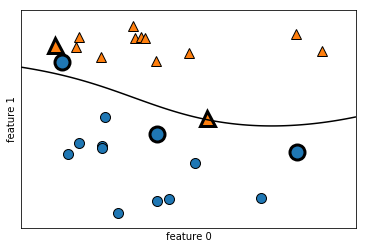

In [48]:
mglearn.plots.plot_2d_separator(svm, X, eps = .5)
mglearn.discrete_scatter(X[:,0], X[:,1],y)

# support vector
sv = svm.support_vectors_
# dual_coef_의 부호에 의해 support vector의 클래스 레이블이 결정된다.
sv_labels = svm.dual_coef_.ravel()>0

mglearn.discrete_scatter(sv[:,0],sv[:,1],sv_labels, s=15, markeredgewidth=3)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

* gamma 매개변수는 가우시안 커널 폭의 역수에 해당함. '하나의 훈련 샘플이 미치는 영향의 범위'를 결정한다. (작은 값 = 넓은 영역, 큰 값 = 작은 영역.)

(margin이라고 생각하면 되려나?)

작은 gamma = 커널의 반경을 크게 한다 = reg 효과가 커진다. 경계가 부드러운 편. 모델 복잡도를 낮춤(결정 경계가 천천히 바뀌기 때문.)

=== 비탄력적인 경계. 데이터의 추가에 따라 경계가 변하는 정도가 작아진다.

큰 gamma = 탄력적인 경계. 모델 복잡도가 올라감.


* C는 선형모델에서 쓴 것과 비슷한 regularization.
C값이 커질수록 결정 경계가 휘어진다. 작을수록 선형에 가까워짐.


매개변수가 다를 경우 = 아래 그림.




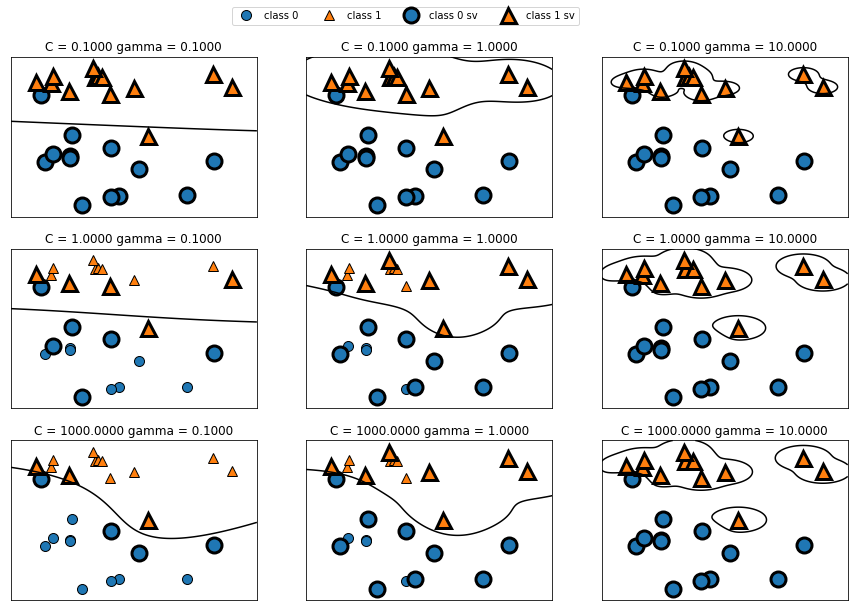

In [53]:
fig, axes = plt.subplots(3,3,figsize=(15,10))
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1,2)):
        mglearn.plots.plot_svm(log_C = C, log_gamma=gamma, ax = a)
        
axes[0,0].legend(['class 0', 'class 1', 'class 0 sv', 'class 1 sv'],ncol=4, loc=(.9,1.2))

In [56]:
X_train, X_test, y_train, y_test  = train_test_split(
cancer.data, cancer.target, stratify=cancer.target, random_state = 0)

svc = SVC() # 기본값 C = 1, gamma = 1/n_features가 디폴트라고.
# kernel = 'rbf', C = 1, gamma= .1
svc.fit(X_train, y_train)

print("train set acc: {:3f}".format(svc.score(X_train, y_train)))
print("test set acc: {:3f}".format(svc.score(X_test, y_test)))

train set acc: 1.000000
test set acc: 0.629371


### svm은 매개변수 설정과 데이터 스케일에 매우 민감하다. 특히 input의 범위가 비슷해야 한다.

cancer 데이터의 경우 input 데이터 scale이 제각각이라 성능이 좋지 못한 편. rescale이 필요하다.

커널svm에서는 모든 특성 값을 0~1 사이로 처리하는 방법을 사용. MinMaxScaler 전처리 방법도 쓸 수 있고, 

(X - min(X)) /(max(x) - min(x)) 를 사용하면 결과가 반드시 0~1 사이값이 나온다.


Text(0, 0.5, 'feature value')

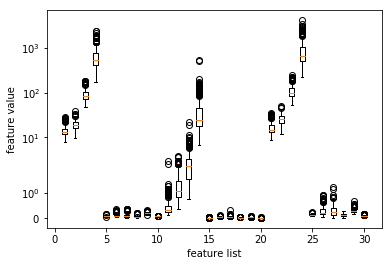

In [58]:
plt.boxplot(X_train, manage_xticks=False)
plt.yscale("symlog")
plt.xlabel('feature list')
plt.ylabel('feature value')